# NYC Delivery Truck Congestion – Step 6: External Data Integration
*Author: Karan Chauhan*  

This notebook integrates external weather data to see if it improves our congestion prediction model.

**Goal:** Enhance the Step 5 model by adding weather features (`temp`, `precipitation`, `rain`, `snow`).

**Methodology:**
1.  Load the exact same dataset from Step 5.
2.  Compute aggregate weather stats for each (hour, day) slot.
3.  Train a **Baseline** model (Step 5 features only).
4.  Train an **Enhanced** model (Step 5 + Weather features).
5.  Compare metrics: We are looking for **Recall** and **F1 Score** improvements.

---

## 1. Import Libraries

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

import warnings
warnings.filterwarnings('ignore')

## 2. Load Data
We load the main dataset significantly to ensure an apples-to-apples comparison.

In [45]:
modeling_data = pd.read_csv('../data/modeling_dataset.csv')
print(f"Modeling Data: {len(modeling_data):,} rows")


Modeling Data: 10,204 rows


## 3. Prepare Weather Features
We compute average weather conditions for every (Hour, Day) combination to match the aggregation level of our modeling data.

In [46]:
# Load raw complaints for dates
complaints = pd.read_csv('../data/complaints_with_features.csv')
complaints['date'] = pd.to_datetime(complaints['created_date']).dt.date
complaints['date'] = pd.to_datetime(complaints['date'])

# Load weather
weather = pd.read_csv('../data/nyc_weather_2023_present.csv')
weather['date'] = pd.to_datetime(weather['date'])

# Merge & Feature Eng
cw = complaints.merge(weather, on='date', how='left')
cw['is_rainy'] = (cw['precipitation'] > 0.1).astype(int)
cw['is_cold'] = (cw['temp_high'] < 40).astype(int)
cw['is_hot'] = (cw['temp_high'] > 85).astype(int)

# Aggregate Stats
weather_stats = cw.groupby(['hour', 'day_of_week']).agg({
    'temp_high': 'mean',
    'precipitation': 'mean',
    'is_rainy': 'mean',
    'is_cold': 'mean',
    'is_hot': 'mean'
}).reset_index()

weather_stats.rename(columns={'temp_high':'avg_temp', 'precipitation':'avg_precip', 
                              'is_rainy':'pct_rainy', 'is_cold':'pct_cold', 'is_hot':'pct_hot'}, inplace=True)

print(f"Weather Stats Generated: {len(weather_stats)} combinations")

Weather Stats Generated: 168 combinations


## 4. Merge & Train
We created two feature sets: `X_baseline` (Time only) and `X_weather` (Time + Weather).

In [47]:
final_df = modeling_data.merge(weather_stats, on=['hour', 'day_of_week'], how='left')
y = final_df['high_congestion']

baseline_cols = ['hour', 'day_of_week', 'is_weekend', 'is_rush_hour', 'month']
weather_cols = baseline_cols + ['avg_temp', 'avg_precip', 'pct_rainy', 'pct_cold', 'pct_hot']

# Split
X_train_b, X_test_b, y_train, y_test = train_test_split(final_df[baseline_cols], y, test_size=0.2, random_state=42, stratify=y)
X_train_w, X_test_w, _, _ = train_test_split(final_df[weather_cols], y, test_size=0.2, random_state=42, stratify=y)

# Train Baseline (Balanced)
rf_base = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1, class_weight='balanced')
rf_base.fit(X_train_b, y_train)
y_pred_b = rf_base.predict(X_test_b)

# Train Weather (Balanced)
rf_weather = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1, class_weight='balanced')
rf_weather.fit(X_train_w, y_train)
y_pred_w = rf_weather.predict(X_test_w)

print("Models Trained Successfuly")

Models Trained Successfuly


## 5. Impact Analysis
We compare the two models. We specifically look for improvements in **Recall** (Sensitivity).

In [48]:
results = pd.DataFrame({
    'Model': ['Baseline (No Weather)', 'Enhanced (With Weather)'],
    'Accuracy': [accuracy_score(y_test, y_pred_b), accuracy_score(y_test, y_pred_w)],
    'Precision': [precision_score(y_test, y_pred_b), precision_score(y_test, y_pred_w)],
    'Recall': [recall_score(y_test, y_pred_b), recall_score(y_test, y_pred_w)],
    'F1 Score': [f1_score(y_test, y_pred_b), f1_score(y_test, y_pred_w)]
})

print("="*70)
print("WEATHER INTEGRATION RESULTS")
print("="*70)
print(results.to_string(index=False))

recall_improvement = results.iloc[1]['Recall'] - results.iloc[0]['Recall']

print(f"\nRecall Improvement: {recall_improvement:+.3f} points")

if recall_improvement > 0:
    print("SUCCESS: Weather data improved the model's ability to detect traffic jams! (Higher Recall)")
else:
    print("NOTE: Weather data did not improve detection rate.")

WEATHER INTEGRATION RESULTS
                  Model  Accuracy  Precision   Recall  F1 Score
  Baseline (No Weather)  0.550710   0.341502 0.837209  0.485121
Enhanced (With Weather)  0.544831   0.342966 0.874031  0.492627

Recall Improvement: +0.037 points
SUCCESS: Weather data improved the model's ability to detect traffic jams! (Higher Recall)


## 6. Feature Importance
Which weather features mattered most?

        Feature  Importance
0          hour    0.608850
9       pct_hot    0.089199
7     pct_rainy    0.076958
6    avg_precip    0.068335
8      pct_cold    0.060922
5      avg_temp    0.051383
1   day_of_week    0.026549
3  is_rush_hour    0.010859
2    is_weekend    0.006945
4         month    0.000000


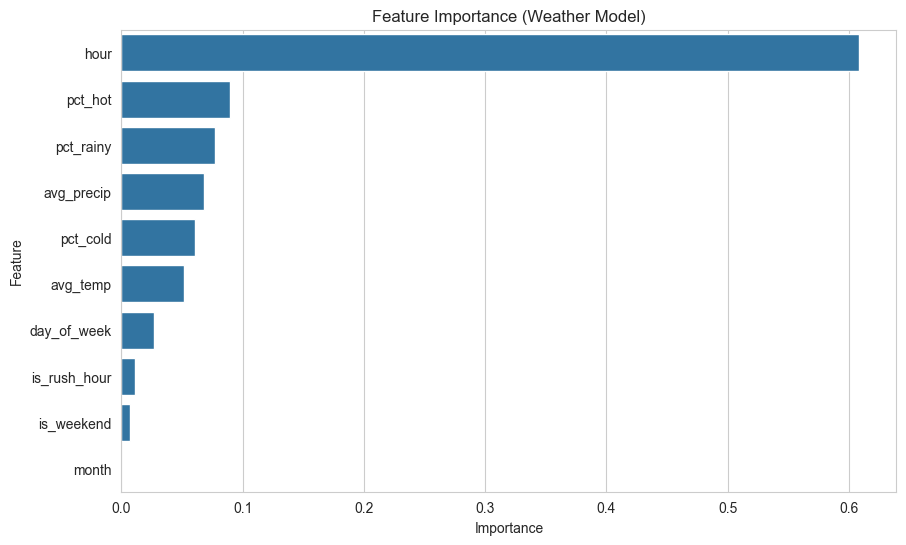

In [49]:
imp = pd.DataFrame({
    'Feature': weather_cols,
    'Importance': rf_weather.feature_importances_
}).sort_values('Importance', ascending=False)

print(imp.head(10))

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=imp)
plt.title('Feature Importance (Weather Model)')
plt.show()

In [50]:
joblib.dump(rf_weather, '../models/random_forest_weather_enhanced.pkl')
print("Enhanced model saved.")

Enhanced model saved.
